# Use VICET to Bound Odometry Errors in LOAM initialized from a moving platform

In [1]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
import time
import pickle

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 4*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import sys
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
from ICET_spherical import ICET
from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
# from pioneer.das.api.platform import Platform #conflict with <open3d-python>
from scipy.spatial.transform import Rotation as R
# from pioneer.das.api.egomotion.imu_egomotion_provider import IMUEgomotionProvider as emp #conflict with <open3d-python>
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

2023-06-21 15:49:07.353434: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 15:49:07.444687: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-21 15:49:07.834756: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/derm/anaconda3/envs/py39/lib/python3.9/site-packages/cv2/../../lib64:
2023-06-21 15:49:07.834810: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_p

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-06-21 15:49:08.503641: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 15:49:08.504394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-21 15:49:08.504611: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-21 15:49:08.504751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Autosaving every 180 seconds


## Load HD Map from .ply File

In [2]:
import trimesh
pl = '/media/derm/06EF-127D3/Newer College Dataset/new-college-29-01-2020-1cm-resolution-1stSection - mesh.ply'
HD_map = trimesh.load(pl).vertices
show_nth = 10 #10
submap = HD_map[::show_nth]

print(np.shape(submap))
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
disp.append(Points(submap, c = "#CB2314", r = 2, alpha = 0.1))  
plt.show(disp, "HD Map")
ViewInteractiveWidget(plt.window)

(402461, 3)


ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)

## Load "Ground Truth" Poses provided in dataset

In [7]:
# [sec,nsec,x,y,z,qx,qy,qz,qw]
fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/05_Quad_With_Dynamics/registered_poses.csv"
# fn_gt = "/media/derm/06EF-127D3/Newer College Dataset/06_Dynamic_Spinning/registered_poses.csv"

gt = np.loadtxt(fn_gt, delimiter=',',skiprows = 1)
seconds = gt[:, 0]
nano_seconds = gt[:, 1]
xyz = gt[:, 2:5]
qxyzw = gt[:, 5:]
num_poses = qxyzw.shape[0]
poses = np.eye(4, dtype=np.float64).reshape(1, 4, 4).repeat(num_poses, axis=0)
poses[:, :3, :3] = R.from_quat(qxyzw).as_matrix()
poses[:, :3, 3] = xyz
T_CL = np.eye(4, dtype=np.float32)
T_CL[:3, :3] = R.from_quat([0.0, 0.0, 0.924, 0.383]).as_matrix() #Kitware API specify offset as -134.97 deg
T_CL[:3, 3] = np.array([-0.084, -0.025, 0.050], dtype=np.float32)
# T_CL[:3, :3] = R.from_euler('xyz', [0,0, np.deg2rad(135)]).as_matrix() #as specified by paper (exactly 45 deg)
poses = np.einsum("nij,jk->nik", poses, T_CL)
initial_pose = np.linalg.inv(poses[0]) 
poses_timestamps = seconds * 10e9 + nano_seconds
poses = np.einsum("ij,njk->nik", np.linalg.inv(poses[0]), poses)
poses_eul = R.from_matrix(poses[:,:3,:3]).as_euler('xyz')
# print(poses_eul)

<IPython.core.display.Javascript object>


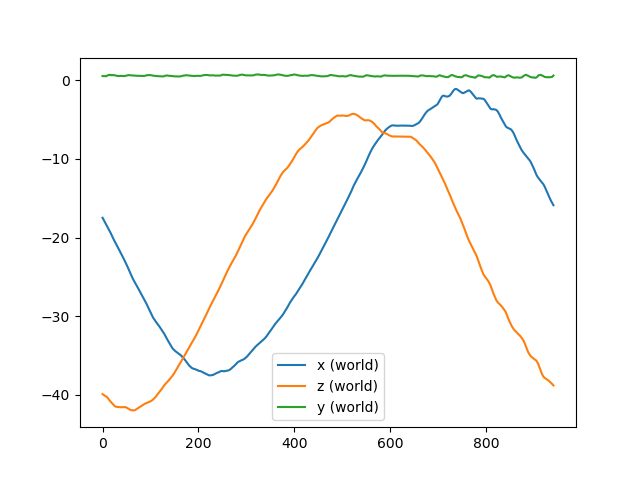

In [8]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
start_idx = 2400
end_idx = 3341

#plot GT
ax.plot(poses[start_idx:end_idx,:3,3], label={'x (world)',"y (world)","z (world)"})
# ax.plot(np.diff(poses[start_idx:end_idx,:3,3], axis = 0), label={'x',"y","z"})
# ax.plot(poses_eul)
# ax.plot(np.diff(poses_eul, axis=0))
ax.legend(loc="best")

## Load LOAM results (starting at arbitrary scan idx) and plot against ground truth

#### NOTE: axis will not be aligned!!!

<IPython.core.display.Javascript object>


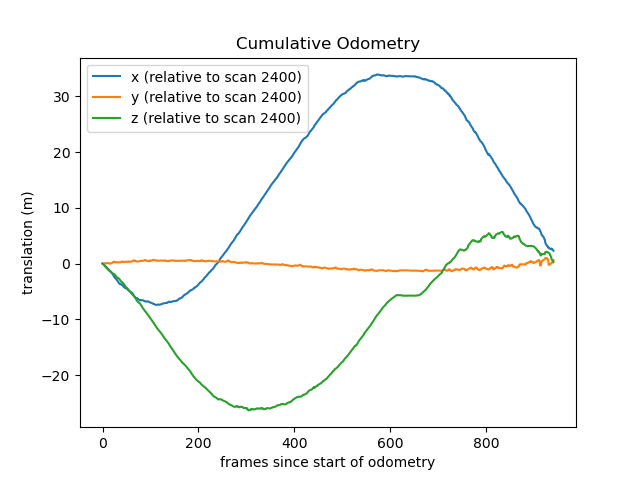

In [14]:
# fn = "results/LOAM/05_test1.npy" #before I got mapmaker working
# fn = "results/LOAM/05_test2.npy" #before I got mapmaker working

# 05_01 after reinstalling EVERYTHING and compiling pcl-1.10 from source
# fn = "results/LOAM/05_test3.npy" # 1650 long 
#makes odom estimates for overall frames 1690-3340 

# # rosbag play --clock -s 54 -r 0.05 rooster_2020-07-10-09-16-39_1.bag 
# fn = "results/LOAM/05_test4.npy" 

# # rosbag play --clock -s 55 -r 0.05 rooster_2020-07-10-09-16-39_1.bag
# fn = "results/LOAM/05_test5.npy" #1100 frames long, starts at 2241 

# start at 2400- very obvious forward motion distortion ()
# rosbag play --clock -s 70.9 -r 0.05 rooster_2020-07-10-09-16-39_1.bag
fn = "results/LOAM/05_test6.npy" #playback at 0.05x speed
# fn = "results/LOAM/05_test7.npy" #playback at 0.2x speed
# fn_fast = "results/LOAM/05_test8.npy" #playback at 1.0x speed (bad)

LOAM_traj = np.load(fn)
# LOAM_traj = np.diff(np.load(fn), axis = 0)

from matplotlib import pyplot as plt
fig, ax = plt.subplots()
ax.plot(LOAM_traj[:,0], label = "x (relative to scan %i)" %start_idx)
ax.plot(LOAM_traj[:,1], label = "y (relative to scan %i)" %start_idx)
ax.plot(LOAM_traj[:,2], label = "z (relative to scan %i)" %start_idx)
ax.set_title("Cumulative Odometry")
ax.set_xlabel("frames since start of odometry")
ax.set_ylabel("translation (m)")
ax.legend(loc="best")

# Plot GT and LOAM in 3D against HD Map 

### TODO: center map about first point in LOAM trajectory

In [133]:
plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4
disp=[]
start_idx = 2400 #overall of GT that corresponds to scan where LOAM begins
end_idx = 3341

#draw HD Map -------------------------------------------
# disp.append(Points(submap, c = "grey", r = 2, alpha = 0.1))
submap_mapframe = (initial_pose @ np.append(submap, np.ones([len(submap),1]), axis =1).T).T
# print(np.shape(submap_mapframe))
submap_lidarframe = submap_mapframe[:,:3] - poses[start_idx][:3,3]
# print(np.shape(submap_lidarframe))
disp.append(Points(submap_lidarframe, c = "grey", r = 2, alpha = 0.1)) ##CB2314

#draw ground truth trajectory -------------------------
# disp.append(Points(gt[start_idx:end_idx,2:5], c = "purple", r=3))#, alpha = 0.2)) #for debug

#transform gt to frame of LOAM_result[idx]
gt_lidarframe = gt[:,2:5]
gt_lidarframe = (initial_pose @ np.append(gt_lidarframe, np.ones([len(gt_lidarframe),1]), axis = 1).T).T
gt_lidarframe[:,:3] -= gt_lidarframe[start_idx,:3]
disp.append(Points(gt_lidarframe[start_idx:end_idx,:3], c = "blue", r=3))#, alpha = 0.2))

# #draw arrows showing heading
# for i in range(start_idx, end_idx,100):
#     rot_m = R.from_quat(gt[i,5:]).as_matrix()
#     arrow_end = gt_lidarframe[i,:3] + rot_m @ np.array([2.,0.,0.])
#     disp.append(Arrow(gt_lidarframe[i,:3], arrow_end, c='red'))

disp.append(Points(LOAM_traj[:,:3], c = 'black', r = 3, alpha = 0.5))  
plt.show(disp, "LOAM vs Ground Truth")


ViewInteractiveWidget(plt.window)

ViewInteractiveWidget(height=1043, layout=Layout(height='auto', width='100%'), width=1280)